<a href="https://colab.research.google.com/github/Kan-0102/DCGAN/blob/main/pytorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

#torch関連
import torch
import torch.nn as nn
import torch.optim as optim
import torchsummary
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, random_split

In [ ]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


**データセット生成**

In [ ]:
# データセットのルートディレクトリ
dataroot = "/content/drive/MyDrive/malimg_paper_dataset_imgs_bicubic"

# トレーニングのバッチサイズ　(クラス数で割り切れる数にすること)
batch_size = 100

# トレーニング画像の空間サイズ。
# すべての画像はトランスフォーマーを使用してこのサイズに変更される→画像補間に変える必要あり
# image_size = 64

# データローダーのワーカー数
workers = 2

#クラス数
label_class = 25

ngpu = 1

Train dataset size: 4314
Test dataset size: 1079
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


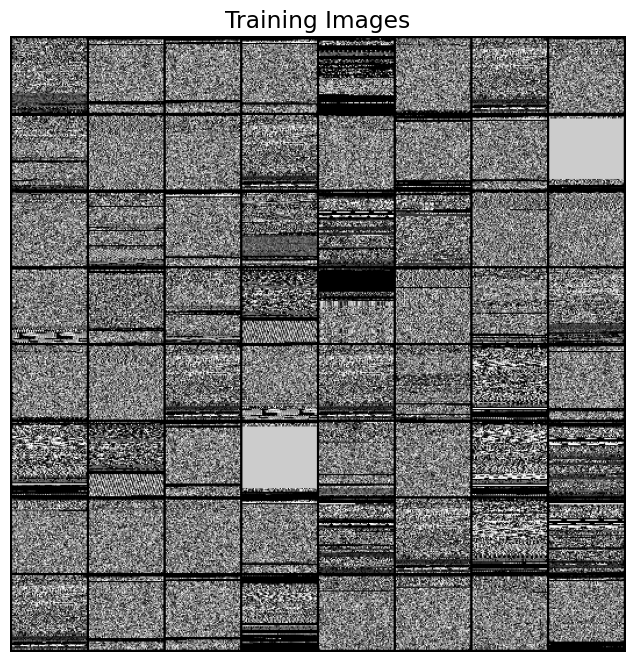

In [ ]:
# データセットのインスタンスを作成
dataset = datasets.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Grayscale(num_output_channels=1),  # グレースケールに変換
                                #    transforms.Resize((64, 64)),  # 64x64にリサイズ
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (0.5,)),  # チャネル数が1のため平均と標準偏差も1つだけ指定
                               ]))

# データセット全体のサイズを取得
dataset_size = len(dataset)

# データセットを分割する割合を指定
train_ratio = 0.8  # 例: 訓練データ80%, テストデータ20%

# データセットを訓練用とテスト用に分割
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

# 分割したデータセットを作成
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaderを使用してデータセットをバッチごとに読み込む
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 訓練データとテストデータのサンプル数を確認
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

# トレーニング画像をプロットする
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
print(type(train_loader))
print(type(test_loader))

In [ ]:
# データローダーからサンプルを取得
for images, labels in train_loader:
    # 最初のバッチのラベルを表示
    print("Labels of the first batch:", labels)
    break


Labels of the first batch: tensor([15, 10, 21,  2,  9,  4, 23,  3, 17,  9, 12,  2, 10, 17,  4,  2, 10, 17,
         7,  7, 17,  2, 14,  3, 23, 11, 23, 19,  6, 10,  3,  7,  9, 23,  3, 12,
         3, 15,  6,  6, 16,  2, 22,  4,  6,  7,  8, 21,  6, 23,  4, 10, 20,  3,
        14, 12,  9,  7,  8, 18,  2,  4, 10,  8])


In [ ]:
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [ ]:
# 損失計算用
def eval_loss(loader, device, net, criterion):
    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)
    # 予測計算
    outputs = net(inputs)
   #  損失計算
    loss = criterion(outputs, labels)
    return loss

In [ ]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)

    for epoch in range(base_epochs, num_epochs+base_epochs):
        # 1エポックあたりの正解数(精度計算用)
        n_train_acc, n_val_acc = 0, 0
        # 1エポックあたりの累積損失(平均化前)
        train_loss, val_loss = 0, 0
        # 1エポックあたりのデータ累積件数
        n_train, n_test = 0, 0

        #訓練フェーズ
        net.train()

        for inputs, labels in tqdm(train_loader):
            # 1バッチあたりのデータ件数
            train_batch_size = len(labels)
            # 1エポックあたりのデータ累積件数
            n_train += train_batch_size

            # GPUヘ転送
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測ラベル導出
            predicted = torch.max(outputs, 1)[1]

            # 平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            train_loss += loss.item() * train_batch_size
            n_train_acc += (predicted == labels).sum().item()

        #予測フェーズ
        net.eval()

        for inputs_test, labels_test in test_loader:
            # 1バッチあたりのデータ件数
            test_batch_size = len(labels_test)
            # 1エポックあたりのデータ累積件数
            n_test += test_batch_size

            # GPUヘ転送
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            # 予測計算
            outputs_test = net(inputs_test)

            # 損失計算
            loss_test = criterion(outputs_test, labels_test)

            # 予測ラベル導出
            predicted_test = torch.max(outputs_test, 1)[1]

            #  平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            val_loss +=  loss_test.item() * test_batch_size
            n_val_acc +=  (predicted_test == labels_test).sum().item()

        # 精度計算
        train_acc = n_train_acc / n_train
        val_acc = n_val_acc / n_test
        # 損失計算
        avg_train_loss = train_loss / n_train
        avg_val_loss = val_loss / n_test
        # 結果表示
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {val_acc:.5f}')
        # 記録
        item = np.array([epoch+1, avg_train_loss, train_acc, avg_val_loss, val_acc])
        history = np.vstack((history, item))
    return history

In [ ]:
# 学習ログ解析

def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}')
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

In [ ]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 3次元に拡張して表示 (グレースケールをRGBに変換)
        img_rgb = np.repeat(img, 3, axis=2)
        plt.imshow(img_rgb, cmap='gray')  # グレースケールとして表示

        # # 結果表示
        # plt.imshow(img)
        ax.set_axis_off()
    plt.show()

In [ ]:
# イメージとラベル表示(ちょっと改造版)
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name, c=c, fontsize=20)
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()


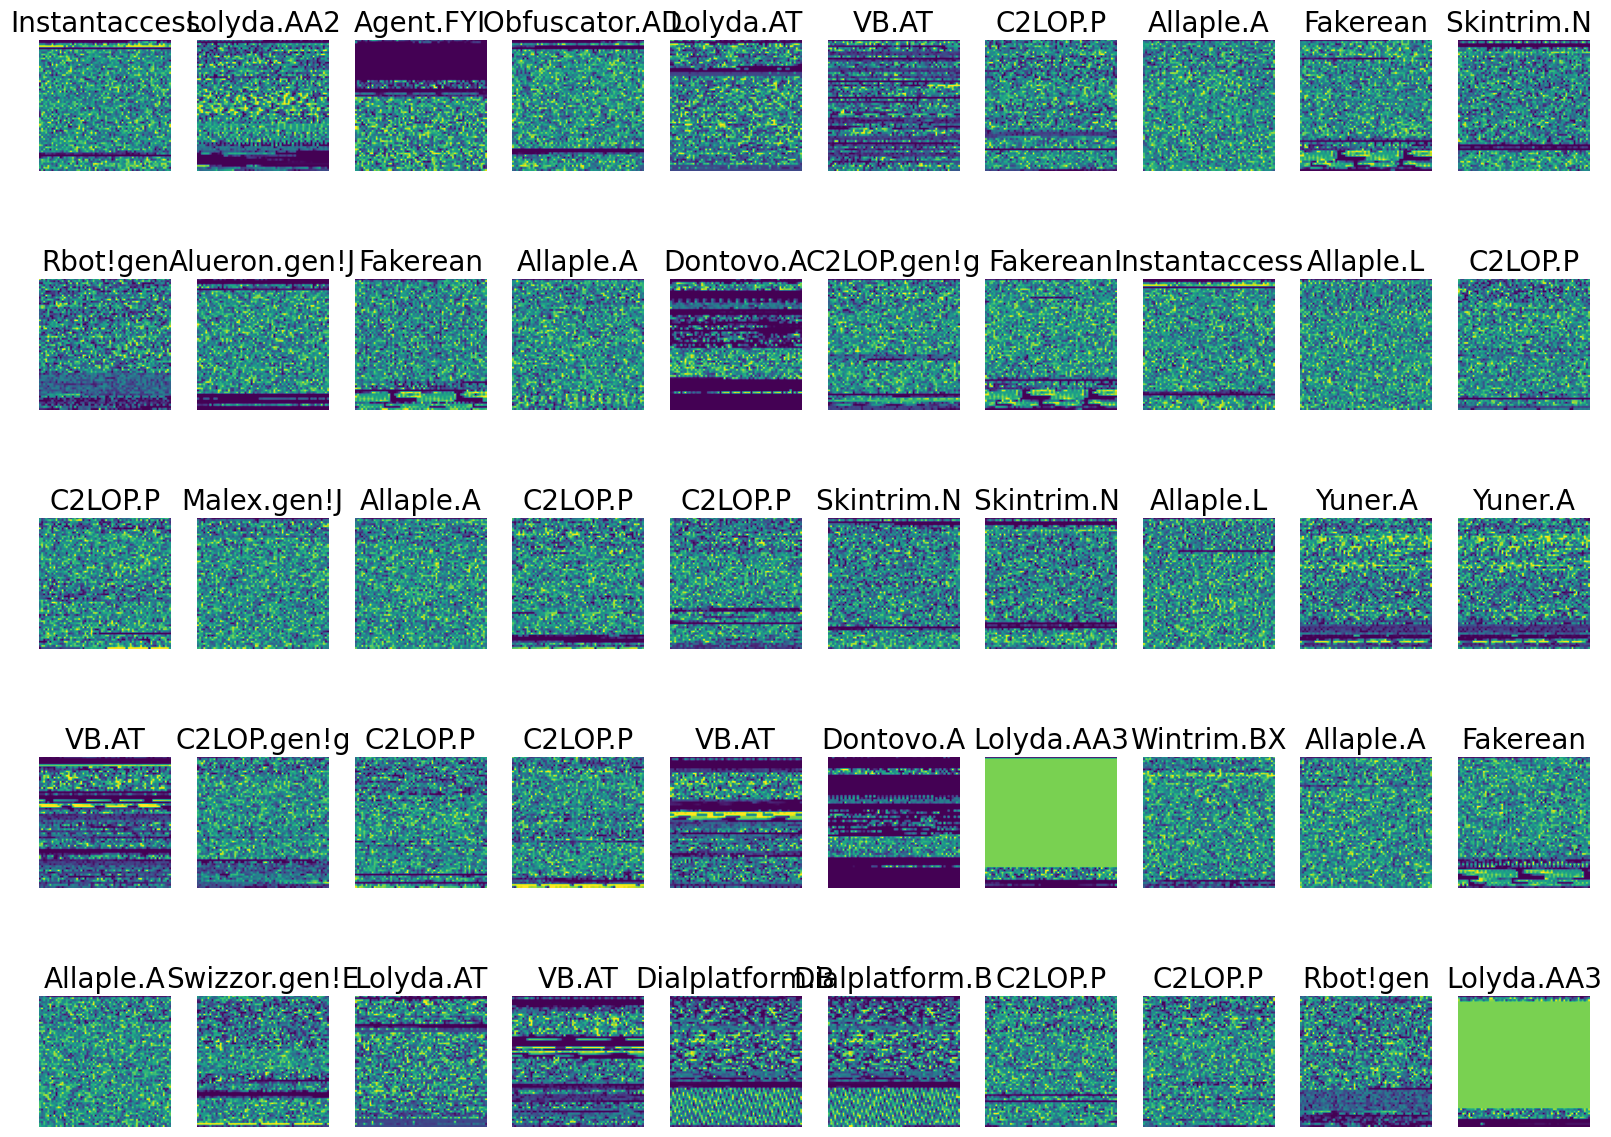

In [ ]:
# 正解ラベル定義
classes = ('Adialer.C ', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J',
           'Autorun.K', 'C2LOP.gen!g', 'C2LOP.P', 'Dialplatform.B', 'Dontovo.A',
           'Fakerean', 'Instantaccess', ' Lolyda.AA1 ', 'Lolyda.AA2', 'Lolyda.AA3',
           'Lolyda.AT', 'Malex.gen!J', ' Obfuscator.AD', 'Rbot!gen', 'Skintrim.N '
           , 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A',
           )

# 検証データ最初の50個の表示
show_images_labels(test_loader, classes, None, None)

In [ ]:
image1, label1 = train_loader.dataset[0]


# 入力次元数 1*64*64=4096
n_input = image1.view(-1).shape[0]

# 出力次元数
# 分類先クラス数　今回は10になる
n_output = len(classes)

# 隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 4096  n_hidden: 128 n_output: 24


In [ ]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 64,kernel_size = 3)
    self.conv2 = nn.Conv2d(64, 64, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(57600, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)

    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3

In [ ]:
# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)


print(net)
torchsummary.summary(net, (1,64,64))

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=57600, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=24, bias=True)
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=57600, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=24, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)         

In [ ]:
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history2 = np.zeros((0,5))

# 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history2)

  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [1/50], loss: 2.42926 acc: 0.38108 val_loss: 1.41126, val_acc: 0.62465


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.87713 acc: 0.75081 val_loss: 0.67278, val_acc: 0.80074


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.54099 acc: 0.82522 val_loss: 0.65368, val_acc: 0.76738


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.44993 acc: 0.85489 val_loss: 0.61170, val_acc: 0.78591


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.39961 acc: 0.88039 val_loss: 0.37317, val_acc: 0.87396


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.29748 acc: 0.91609 val_loss: 0.45136, val_acc: 0.85264


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.26973 acc: 0.92350 val_loss: 0.25991, val_acc: 0.91844


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.22471 acc: 0.93440 val_loss: 0.27921, val_acc: 0.90547


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.19247 acc: 0.94112 val_loss: 0.23655, val_acc: 0.91937


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.16363 acc: 0.95410 val_loss: 1.22285, val_acc: 0.71918


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.21051 acc: 0.94692 val_loss: 0.20717, val_acc: 0.93420


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.15206 acc: 0.95967 val_loss: 0.21141, val_acc: 0.93513


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.10978 acc: 0.96987 val_loss: 0.20616, val_acc: 0.92678


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.10576 acc: 0.97033 val_loss: 0.17555, val_acc: 0.94625


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.09447 acc: 0.97983 val_loss: 0.18968, val_acc: 0.93791


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.07918 acc: 0.97960 val_loss: 0.28067, val_acc: 0.90083


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.07035 acc: 0.97983 val_loss: 0.25282, val_acc: 0.90825


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.07216 acc: 0.98192 val_loss: 0.17691, val_acc: 0.93976


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.05071 acc: 0.98980 val_loss: 0.17365, val_acc: 0.93698


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.04353 acc: 0.99212 val_loss: 0.18354, val_acc: 0.93791


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.03934 acc: 0.99328 val_loss: 0.16504, val_acc: 0.94069


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.03594 acc: 0.99235 val_loss: 0.19644, val_acc: 0.93234


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.02990 acc: 0.99629 val_loss: 0.16886, val_acc: 0.93883


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.02742 acc: 0.99583 val_loss: 0.17913, val_acc: 0.94161


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.02439 acc: 0.99583 val_loss: 0.16151, val_acc: 0.94439


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.02334 acc: 0.99629 val_loss: 0.17598, val_acc: 0.94439


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.01691 acc: 0.99954 val_loss: 0.18200, val_acc: 0.94439


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.01448 acc: 0.99930 val_loss: 0.17618, val_acc: 0.94347


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.01346 acc: 0.99907 val_loss: 0.21681, val_acc: 0.92678


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.01181 acc: 0.99954 val_loss: 0.17359, val_acc: 0.94347


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.01080 acc: 0.99954 val_loss: 0.16516, val_acc: 0.94347


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.01242 acc: 0.99861 val_loss: 0.16794, val_acc: 0.94439


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.00933 acc: 0.99977 val_loss: 0.17633, val_acc: 0.94532


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.00809 acc: 1.00000 val_loss: 0.17467, val_acc: 0.94439


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.00717 acc: 1.00000 val_loss: 0.17143, val_acc: 0.94625


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.00651 acc: 1.00000 val_loss: 0.17495, val_acc: 0.94532


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.00606 acc: 1.00000 val_loss: 0.16902, val_acc: 0.94347


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.00564 acc: 1.00000 val_loss: 0.17207, val_acc: 0.94532


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.00540 acc: 1.00000 val_loss: 0.17123, val_acc: 0.94532


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.00509 acc: 1.00000 val_loss: 0.17529, val_acc: 0.94439


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.00460 acc: 1.00000 val_loss: 0.17021, val_acc: 0.94439


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.00428 acc: 1.00000 val_loss: 0.17182, val_acc: 0.94625


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.00423 acc: 1.00000 val_loss: 0.17503, val_acc: 0.94625


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.00385 acc: 1.00000 val_loss: 0.17847, val_acc: 0.94439


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.00370 acc: 1.00000 val_loss: 0.17638, val_acc: 0.94347


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.00351 acc: 1.00000 val_loss: 0.17718, val_acc: 0.94532


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00336 acc: 1.00000 val_loss: 0.17607, val_acc: 0.94625


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00322 acc: 1.00000 val_loss: 0.17853, val_acc: 0.94625


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00302 acc: 1.00000 val_loss: 0.17891, val_acc: 0.94347


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00292 acc: 1.00000 val_loss: 0.17693, val_acc: 0.94439


初期状態: 損失: 1.41126 精度: 0.62465
最終状態: 損失: 0.17693 精度: 0.94439


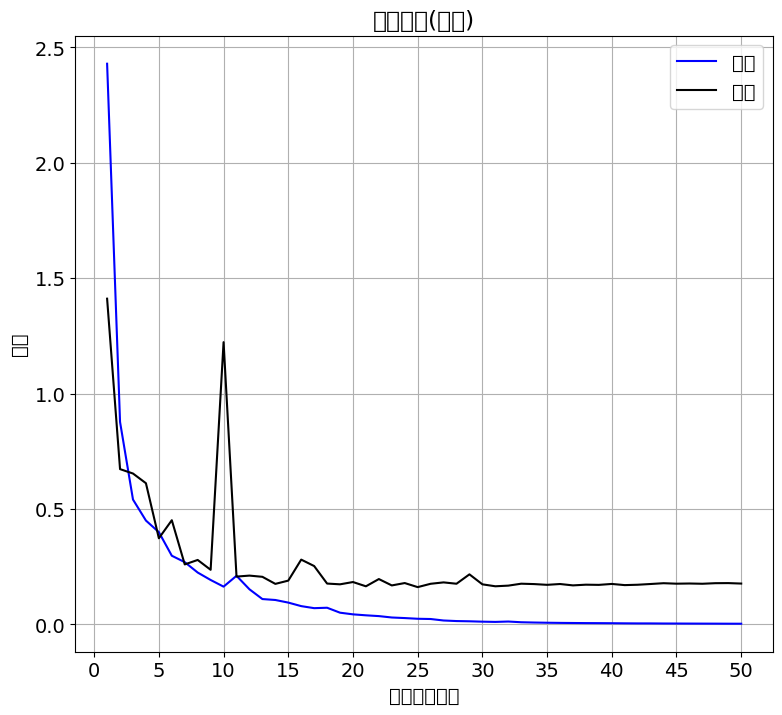

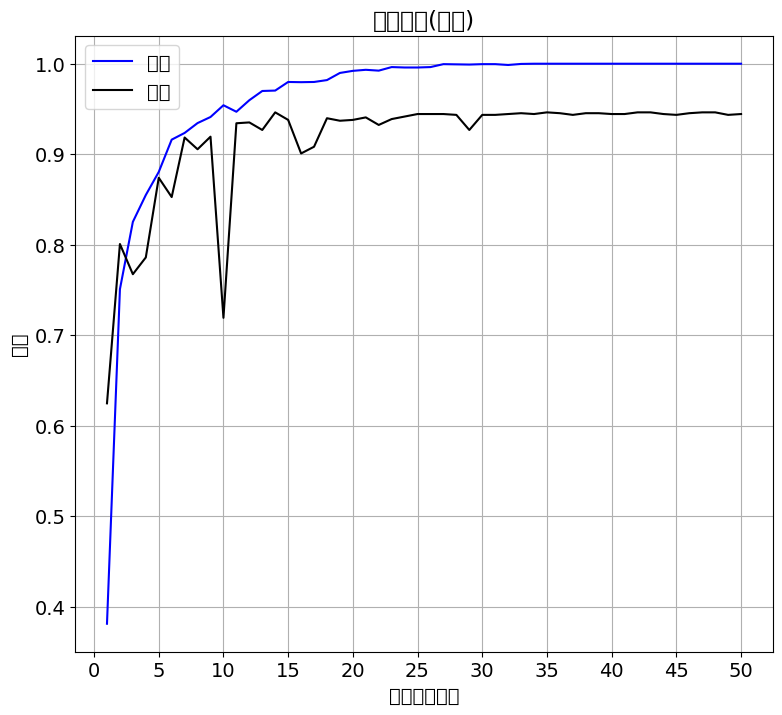

In [ ]:
# 評価

evaluate_history(history2)

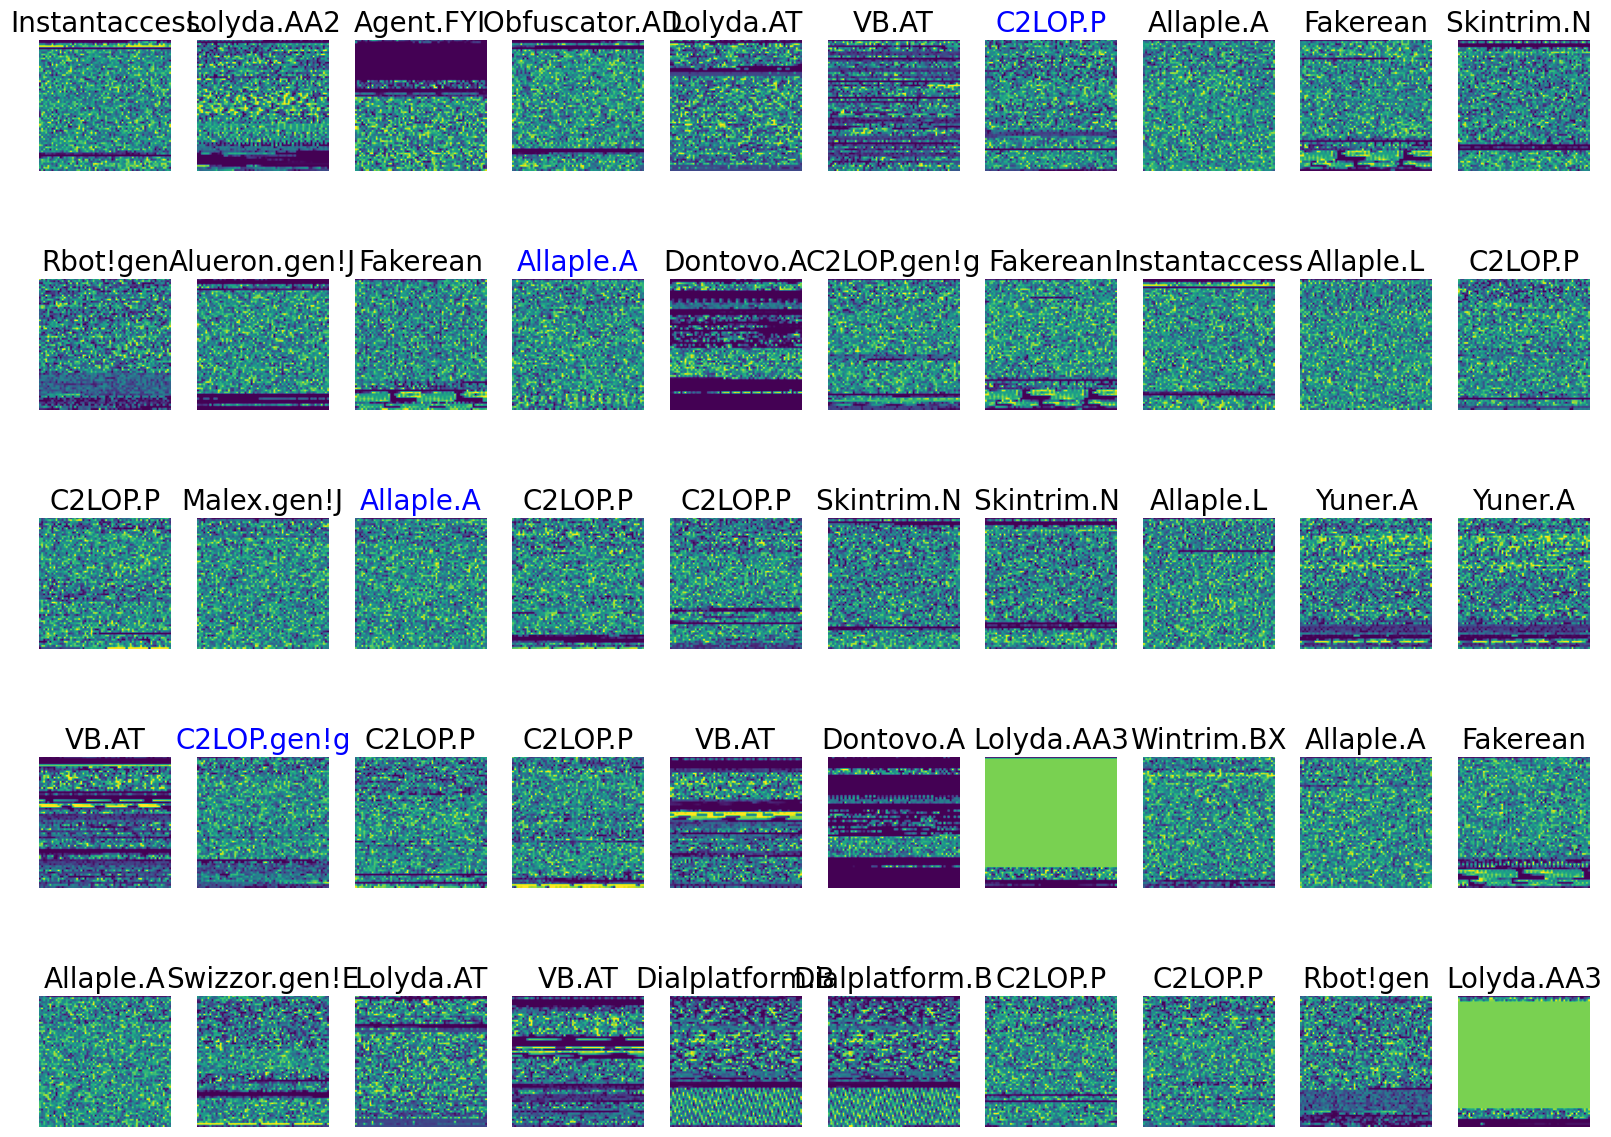

In [ ]:
# 最初の50個の表示

show_images_labels(test_loader, classes, net, device)

In [ ]:
# # モデルの保存
# torch.save(net.state_dict(), '/content/drive/MyDrive/4_CNNmodel/model.pth')
# # モデルの読み込み
# net.load_state_dict(torch.load('/content/drive/MyDrive/4_CNNmodel/model.pth'))

In [ ]:
# # モデルとアーキテクチャの保存
# torch.save({
#     'model_state_dict': net.state_dict(),
#     'model_architecture': CNN  # <- インスタンスを作成しない
# }, '/content/drive/MyDrive/4_CNNmodel/model_with_arch.pth')


In [ ]:
# # モデルの読み込み
# checkpoint = torch.load('/content/drive/MyDrive/4_CNNmodel/model_with_arch.pth')
# loaded_model = CNN(n_output=25, n_hidden=128)  # インスタンスを作成
# loaded_model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
# net.eval()

In [ ]:
# モデルをGPUに移動
net.to(device)

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # テンソルをGPUに送る
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


In [ ]:
accuracy = correct / total
print('Accuracy on test data: {:.2%}'.format(accuracy))

Accuracy on test data: 94.44%


In [ ]:
num_classes = 24  # クラスの総数
class_accuracy = [0] * num_classes
class_samples = [0] * num_classes


with torch.no_grad():
    for inputs, labels in test_loader:  # test_loaderはテストデータセットのデータローダーと仮定しています
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)

        for c in range(num_classes):
            class_samples[c] += (labels == c).sum().item()
            class_accuracy[c] += ((predicted == c) & (labels == c)).sum().item()

# クラスごとの精度を計算
for c in range(num_classes):
    if class_samples[c] > 0:
        accuracy = class_accuracy[c] / class_samples[c]
        print(f'{accuracy:.2%}')
    else:
        print(f'No samples for class {c}')


100.00%
100.00%
90.74%
97.03%
96.97%
67.74%
76.32%
97.50%
100.00%
97.50%
100.00%
94.59%
100.00%
100.00%
96.55%
96.43%
100.00%
100.00%
100.00%
68.00%
56.00%
98.72%
100.00%
100.00%


In [ ]:
# from google.colab import runtime
# runtime.unassign()